# Filter & denoise

### Contents
0. Install packages
1. Denoising data with the FFT and iFFT
2. Using the NoiseReduce package
3. Another way of filtering (in progress, issues)

## 0. Install packages

In [2]:
!pip install noisereduce

     |████████████████████████████████| 214 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 5.3 MB/s eta 0:00:011
     |████████████████████████████████| 377 kB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 613 kB 8.5 MB/s eta 0:00:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23706 sha256=c3a181d3bbf51484491d8f751aeeb361446afbf8d52697cf6f6a6a1e38c73035
  Stored in directory: /Users/michielbontenbal/Library/Caches/pip/wheels/e4/76/a4/cfb55573167a1f5bde7d7a348e95e509c64b2c3e8f921932c3
Successfully built audioread


## 1. Denoising data with the FFT
source: https://www.youtube.com/watch?v=s2K1JfNR7Sc

<IPython.core.display.Javascript object>


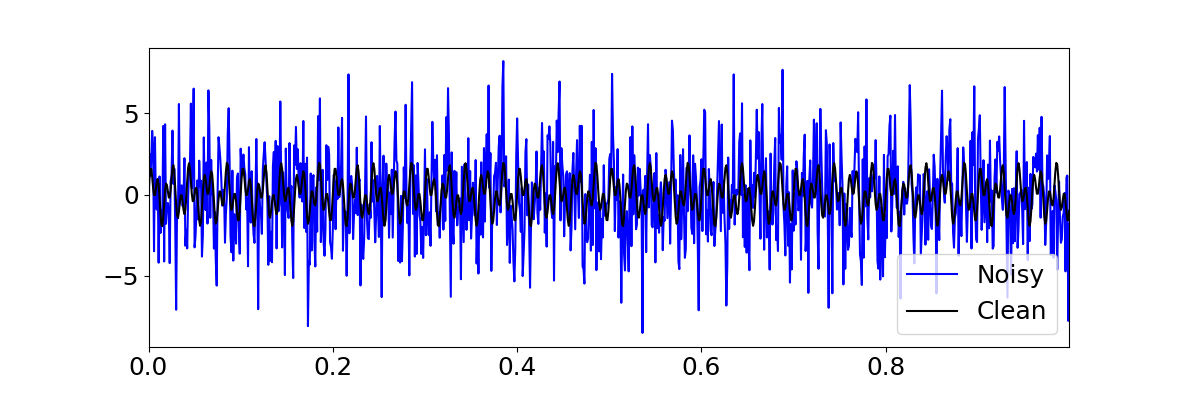

In [25]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']= [12,4]
plt.rcParams.update({'font.size': 18})

#Create a simple signal with two frequencies
dt = 0.001
t = np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2* np.pi*120*t) #sum of 2 frequencies
f_clean = f
f = f + 2.5*np.random.randn(len(t)) #add some noise

plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

<IPython.core.display.Javascript object>


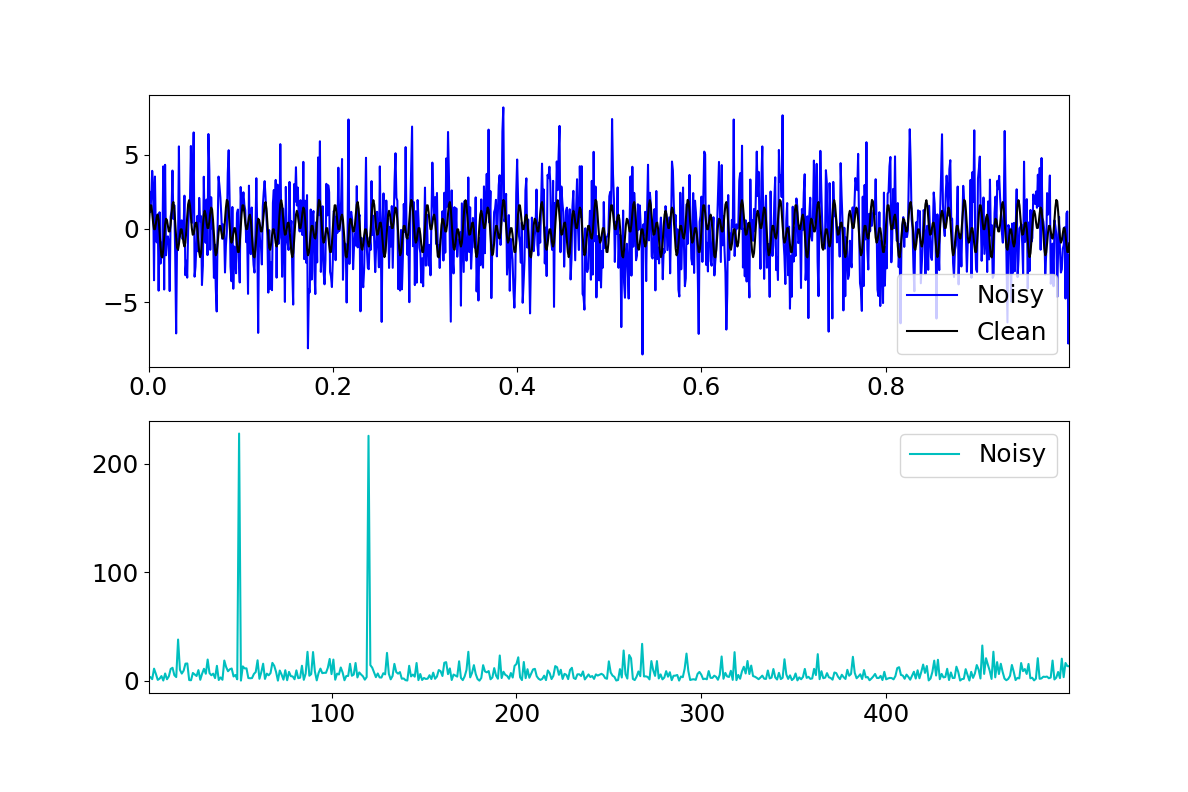

C:\Users\Michiel\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [27]:
# computing the FFT
n = len(t)
fhat = np.fft.fft(f,n) # 
PSD = fhat *np.conj(fhat) /n #PSD = Power Spectral Density
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype = 'int')

plt.rcParams['figure.figsize']= [12,8]
fig, axs = plt.subplots(2,1)

plt.sca(axs[0])
plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L], PSD[L], color = 'c', label ='Noisy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

In [23]:
# create a filter at 100
# use the PSD to filter out the noise

indices = PSD > 100 #find all freqs with large power
PSDclean = PSD * 100 #zero all out others
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

<IPython.core.display.Javascript object>


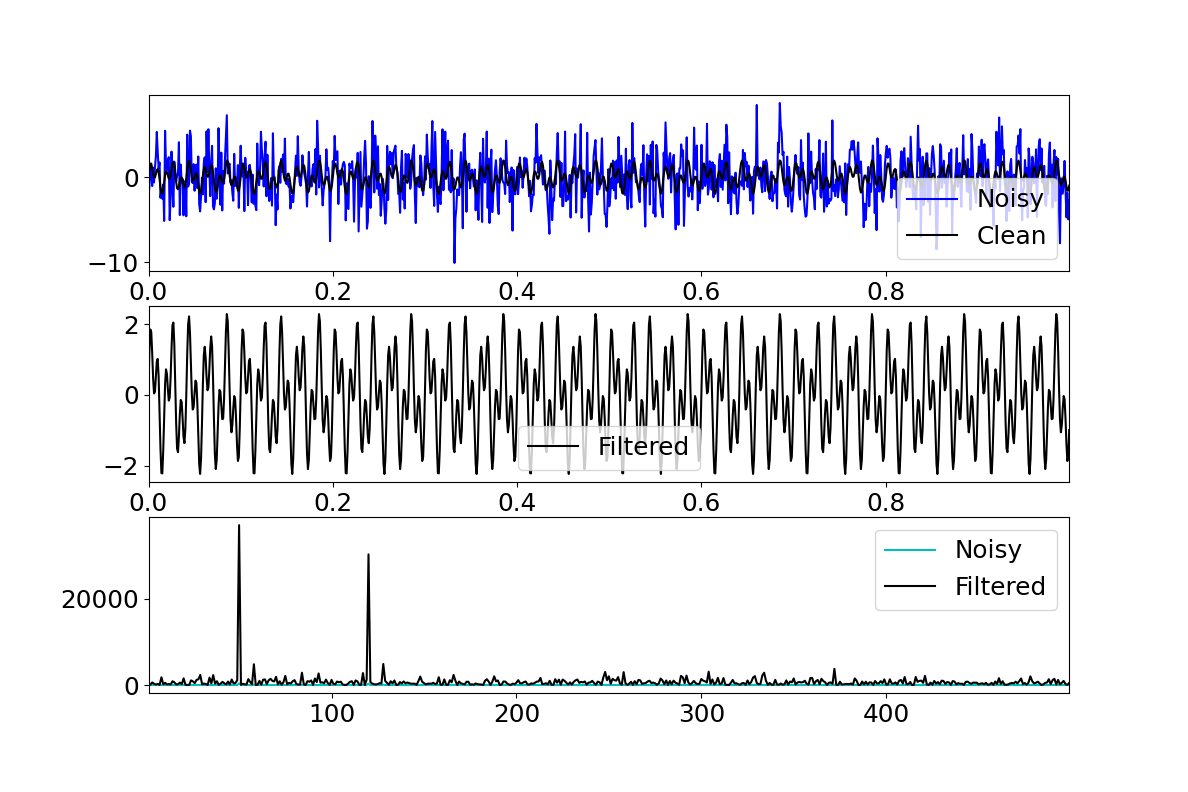

C:\Users\Michiel\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Michiel\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Michiel\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [27]:
figs, axs = plt.subplots(3,1)

plt.sca(axs[0])
plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(t, ffilt, color='k', label='Filtered')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L], PSD[L], color='c', label = 'Noisy')
plt.plot(freq[L], PSDclean[L], color='k', label='Filtered')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

## 2. Noisereduce - first attempt !

### To do:
- trim audio file to max 10 (?)seconds

#### Steps of the Stationary Noise Reduction algorithm
1. A spectrogram is calculated over the noise audio clip
2. Statistics are calculated over spectrogram of the the noise (in frequency)
3. A threshold is calculated based upon the statistics of the noise (and the desired sensitivity of the algorithm)
4. A spectrogram is calculated over the signal
5. A mask is determined by comparing the signal spectrogram to the threshold
6. The mask is smoothed with a filter over frequency and time
7. The mask is appled to the spectrogram of the signal, and is inverted If the noise signal is not provided, the algorithm will treat the signal as the noise clip, which tends to work pretty well

source: https://pypi.org/project/noisereduce/#:~:text=Noise%20reduction%20in%20python%20using,a%20form%20of%20Noise%20Gate.

In [60]:
from glob import glob
my_wavs = glob('*.wav')
print(my_wavs)

['11k16bitpcm.wav', 'claxon_1m.wav', 'claxon_close.wav', 'claxon_freesound.wav', 'claxon_iphone.wav', 'claxon_michiel.wav', 'converted.wav', 'converted2.wav', 'example.wav', 'file.wav', 'loudness.wav', 'miaow_16k.wav', 'my-audio.wav', 'mywav_reduced_noise.wav', 'my_test.wav', 'my_wav.wav', 'new_file.wav', 'noise_add.wav', 'out.wav', 'output.wav', 'piano_c.wav', 'robot0.wav', 'robot1.wav', 'robot2.wav', 'robot3.wav', 'Sample_audio.wav', 'silence.wav', 'speech_whistling2.wav', 'test.wav', 'test2.wav', 'test3.wav', 'tone_220.wav', 'tone_440.wav', 'welcome.wav', 'Yoda.wav']


In [77]:
audio_data = 'Yoda.wav'

In [78]:
len(audio_data)

8

In [63]:
import IPython
IPython.display.Audio(audio_data)

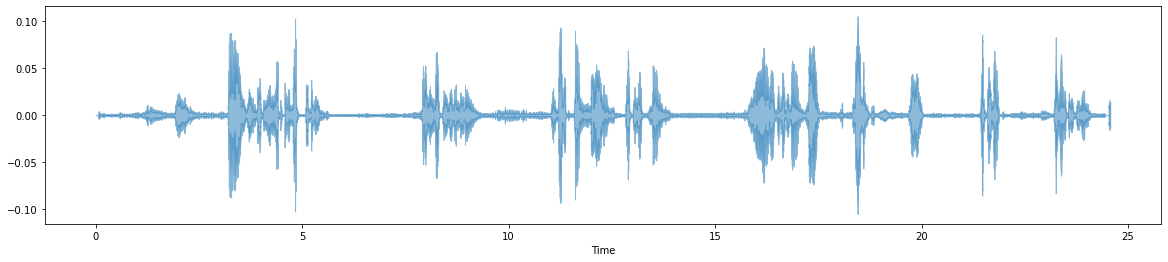

In [80]:
#creating a waveplot
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
import librosa.display
#audio_data = 'claxon_michiel.wav'
data , sr = librosa.load(audio_data) #sr = sampling rate
plt.figure(figsize=(20, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.5) # used to be: librosa.display.waveplot

In [81]:
#source: https://pypi.org/project/noisereduce/#:~:text=Noise%20reduction%20in%20python%20using,a%20form%20of%20Noise%20Gate.
from scipy.io import wavfile
import noisereduce as nr
# load data
librosa.to_mono(data) #convert to mono first
rate, data = wavfile.read(audio_data)
print(rate)
print(type(data))
print(len(data))

44100
<class 'numpy.ndarray'>
1083537


In [82]:
# perform noise reduction
#librosa.to_mono(audio_data)
#data = np.reshape(data, (2, -1)) #source:https://stackoverflow.com/questions/70730921/noisereduce-algorithm-in-python-not-working
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("mywav_reduced_noise2.wav", rate, reduced_noise)

MemoryError: Unable to allocate 484. GiB for an array with shape (1083537, 60002) and data type float64

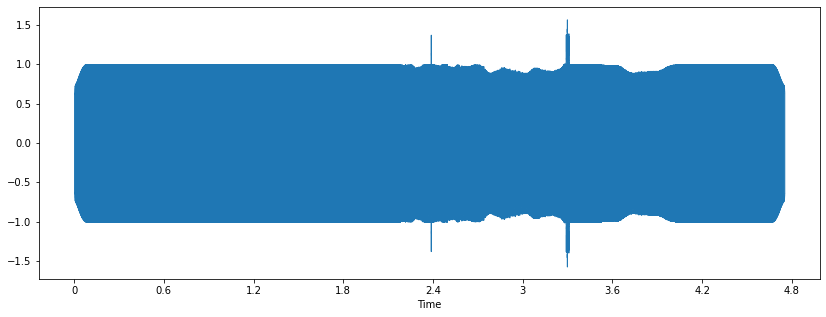

In [40]:
#creating a waveplot
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
import librosa.display
#audio_data = my_wavs[3]
x , sr = librosa.load('mywav_reduced_noise.wav') #sr = sampling rate
plt.figure(figsize=(20, 4))
librosa.display.waveshow(x, sr=sr) # used to be: librosa.display.waveplot

In [41]:
IPython.display.Audio('mywav_reduced_noise.wav')

## 5. Filter audio with scipy.signal (in progress)
source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [3]:
import numpy as np
from scipy.signal import butter, filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [4]:
# sin wave
sig = np.sin(1.2*2*np.pi*T)
# Lets add some noise
noise = 1.5*np.cos(9*2*np.pi*T) + 0.5*np.sin(12.0*2*np.pi*T)
data = sig + noise

In [5]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)
fig = go.Figure()
fig.add_trace(go.Scatter(
            y = data,
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = y,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()

IndexError: tuple index out of range

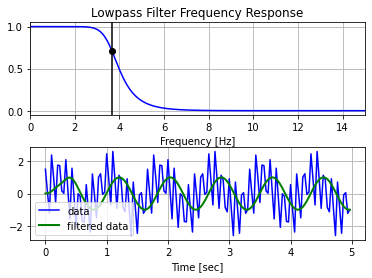

In [6]:
# source

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()